In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_May__3_18:49:52_PDT_2022
Cuda compilation tools, release 11.7, V11.7.64
Build cuda_11.7.r11.7/compiler.31294372_0
torch:  2.0 ; cuda:  cu117
detectron2: 0.6


In [2]:
import os
import sys
import logging
import argparse
os.environ["DATASET"] = "../datasets"

pth = '/'.join(sys.path[0].split('/')[:-1])
sys.path.insert(0, pth)

from pprint import pprint
import numpy as np
np.random.seed(1)

home_dir = os.path.abspath(os.getcwd()+"/../")
sys.path.append(home_dir)
print(home_dir)

import warnings
warnings.filterwarnings(action='ignore')
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

from xdecoder.BaseModel import BaseModel
from xdecoder import build_model
from utils.distributed import init_distributed
from utils.arguments import load_opt_from_config_files, load_config_dict_to_opt

/home/djjin/Github/org-X-Decoder


Invalid MIT-MAGIC-COOKIE-1 key

In [3]:
import yaml
import json
import argparse
import logging
import os

def load_vcoco_parser():
    parser = argparse.ArgumentParser(description='Pretrain or fine-tune models for NLP tasks.')
    parser.add_argument('--command', default="evaluate", help='Command: train/evaluate/train-and-evaluate')
    parser.add_argument('--conf_files', nargs='+', help='Path(s) to the config file(s).')
    parser.add_argument('--user_dir', help='Path to the user defined module for tasks (models, criteria), optimizers, and lr schedulers.')
    parser.add_argument('--config_overrides', nargs='*', help='Override parameters on config with a json style string, e.g. {"<PARAM_NAME_1>": <PARAM_VALUE_1>, "<PARAM_GROUP_2>.<PARAM_SUBGROUP_2>.<PARAM_2>": <PARAM_VALUE_2>}. A key with "." updates the object in the corresponding nested dict. Remember to escape " in command line.')
    parser.add_argument('--overrides', help='arguments that used to override the config file in cmdline', nargs=argparse.REMAINDER)
    cmdline_args = parser.parse_args('')
    return cmdline_args

def load_vcoco_opt_command(cmdline_args):
    opt = load_opt_from_config_files(cmdline_args.conf_files)
    opt["base_path"] = "../"

    keys = [cmdline_args.overrides[idx*2] for idx in range(len(cmdline_args.overrides)//2)]
    vals = [cmdline_args.overrides[idx*2+1] for idx in range(len(cmdline_args.overrides)//2)]
    vals = [val.replace('false', '').replace('False','') if len(val.replace(' ', '')) == 5 else val for val in vals]
    types = []
    for key in keys:
        key = key.split('.')
        ele = opt.copy()
        while len(key) > 0:
            ele = ele[key.pop(0)]
        types.append(type(ele))

    config_dict = {x:z(y) for x,y,z in zip(keys, vals, types)}

    load_config_dict_to_opt(opt, config_dict)
    for key, val in cmdline_args.__dict__.items():
        if val is not None:
            opt[key] = val

    return opt

cmdline_args = load_vcoco_parser()
cmdline_args.conf_files = [os.path.join(home_dir, "configs/xdecoder/segvlp_focalt_lang.yaml")]
# cmdline_args.overrides = ['WEIGHT', 'true', 'RESUME_FROM', '../checkpoints/xdecoder_focalt_best_openseg.pt'] 
cmdline_args.overrides = ['DONT_LOAD_MODEL', 'false', 'PYLEARN_MODEL', '../data/output/test/00062100/default/raw_model_states.pt'] 


opt = load_vcoco_opt_command(cmdline_args)
opt = init_distributed(opt)

In [4]:
from datasets.build import build_train_dataloader
train_data_loader = build_train_dataloader(opt)
dataset_names = opt['DATASETS']['TRAIN']
print(len(train_data_loader))

INFO:datasets.dataset_mappers.coco_panoptic_new_baseline_dataset_mapper:[COCOPanopticNewBaselineDatasetMapper] Full TransformGens used in training: [RandomFlip(), ResizeScale(min_scale=0.1, max_scale=2.0, target_height=1024, target_width=1024), FixedSizeCrop(crop_size=(1024, 1024))]
INFO:datasets.build:Using training sampler TrainingSampler
INFO:detectron2.data.common:Serializing 112580 elements to byte tensors and concatenating them all ...
INFO:detectron2.data.common:Serialized dataset takes 204.50 MiB


56290


[[ 490.  421.  511.  442.]
 [ 671.  434.  719.  471.]
 [   0.    0.    0.    0.]
 [ 257.  520.  304.  542.]
 [ 304.  451.  369.  529.]
 [ 570.  460.  585.  494.]
 [ 786.  488.  807.  531.]
 [ 930.  350.  982.  425.]
 [ 226.  522.  265.  574.]
 [ 451.  421.  490.  460.]
 [ 725.  458.  757.  488.]
 [ 334.  503.  384.  553.]
 [ 516.  466.  570.  512.]
 [   0.  261. 1024.  598.]
 [ 151.  246. 1024.  777.]
 [ 801.  648.  846.  669.]
 [ 414.  574.  496.  660.]
 [   0.    0. 1024.  356.]
 [   0.  227. 1024.  641.]]


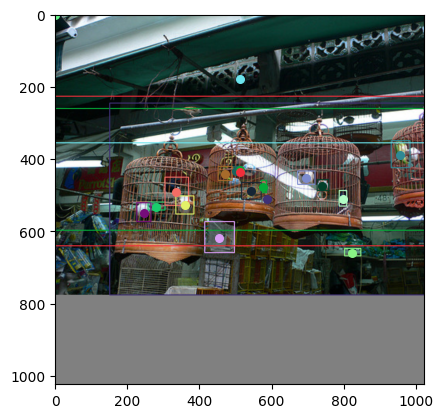

[[ 367.  541.  460.  712.]
 [ 510.  394. 1024.  872.]
 [   0.    0.    0.    0.]
 [  51.  776.  134.  872.]
 [ 186.  725.  447.  908.]
 [ 772.    0. 1024.  361.]
 [  17.  636. 1024. 1024.]
 [ 527.  995. 1024. 1024.]
 [   0.  158.  882.  971.]
 [   0.    0. 1024.  774.]]


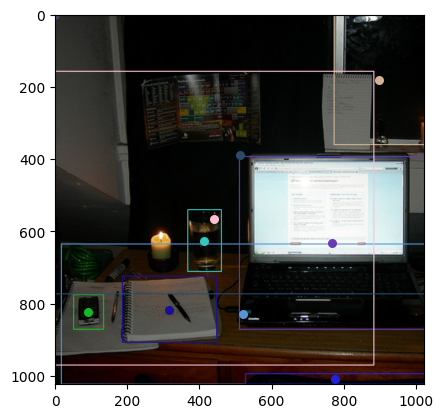

[[   0.  109.   49.  526.]
 [ 323.  198.  343.  255.]
 [ 206.  230.  268.  407.]
 [ 651.  451.  703.  562.]
 [ 141.  223.  227.  470.]
 [ 699.  457.  778.  602.]
 [ 266.  190.  341.  459.]
 [  18.  242.  162.  397.]
 [ 473.  230.  588.  363.]
 [ 580.    4. 1024.  685.]
 [ 139.  395.  381.  675.]
 [  47.    0.  114.  107.]
 [ 231.  146.  367.  201.]
 [ 252.  138.  358.  178.]
 [ 118.  153.  285.  238.]
 [  16.  248. 1024.  921.]
 [   0.   54.  139.  173.]
 [   0.  401.  603.  921.]
 [   0.    0. 1024.  324.]]


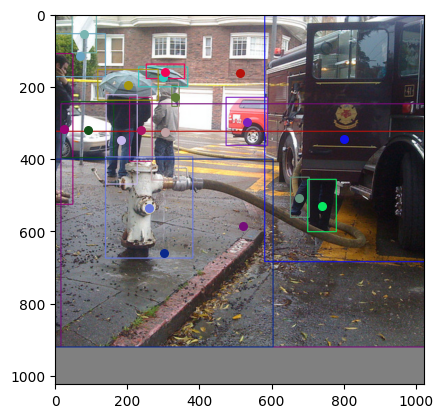

[[179.  78. 197.  93.]
 [163.  78. 171.  95.]
 [320. 143. 331. 165.]
 [205.  85. 211.  92.]
 [306. 144. 317. 166.]
 [219.  89. 223.  94.]
 [ 80. 163.  93. 182.]
 [ 92.  57. 262. 195.]
 [301. 151. 339. 163.]
 [258. 156. 281. 179.]
 [  0.  78.  99. 178.]
 [  0. 151. 371. 248.]
 [  0.  76. 139. 159.]
 [163.  18. 305. 102.]
 [  0.   0. 371. 107.]
 [  9. 127.  80. 168.]
 [ 45. 153.  61. 163.]
 [239.  47. 371. 168.]]


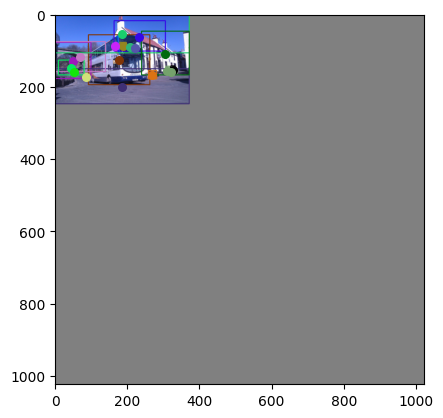

[[265.  85. 550. 490.]
 [234. 484. 575. 523.]
 [  0.   0. 954. 633.]]


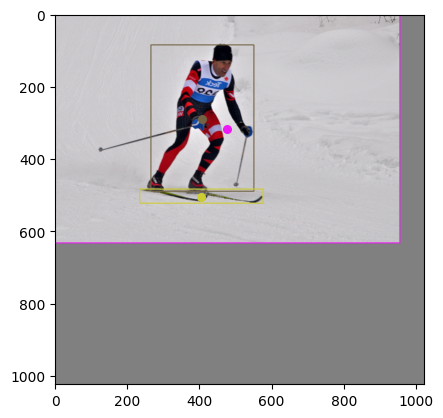

[[ 525.  486.  571.  573.]
 [ 776.  410.  837.  544.]
 [ 574.  407.  784.  573.]
 [ 834.  209. 1024. 1024.]
 [   0.    0.    0.    0.]
 [   0.  433.  854.  836.]
 [   0.  203.  665.  576.]
 [   0.    0.    0.    0.]
 [   0.    0. 1024. 1024.]
 [   0.    0.    0.    0.]
 [ 647.  323.  837.  498.]]


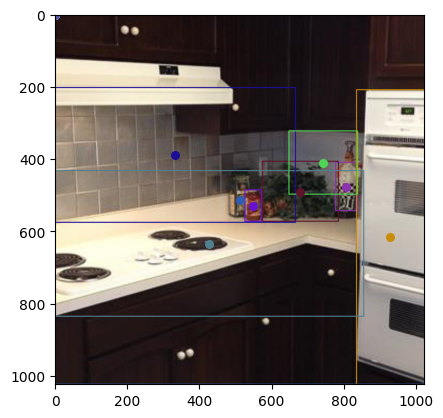

[[122.   1. 168.  51.]
 [304. 163. 336. 195.]
 [115.  12. 363. 176.]
 [  0.  86. 652. 434.]]


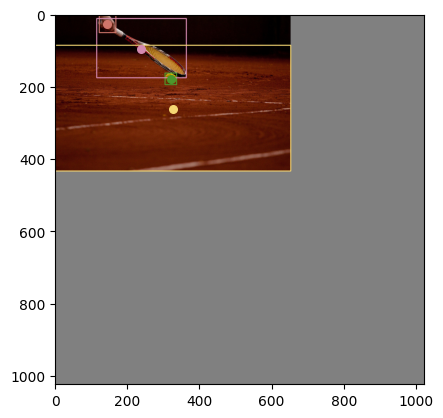

[[   2.  311. 1024.  386.]
 [   0.  386. 1024.  683.]
 [   0.  460. 1024.  892.]
 [   0.  269. 1024.  391.]
 [   0.    0. 1024.  349.]
 [  19.  242. 1024.  345.]
 [ 907.  487. 1024.  541.]]


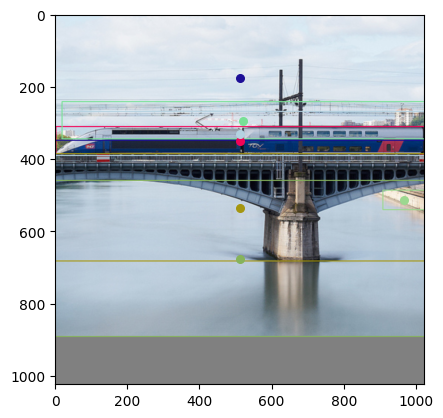

[[ 47.  31.  70.  54.]
 [108.  20. 120.  52.]
 [  0.   0. 120.  79.]]


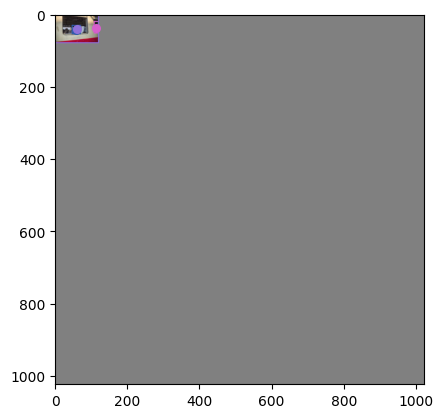

[[228. 120. 436. 205.]
 [443.   5. 568. 113.]
 [ 45.   7. 235. 205.]
 [253.   1. 376.  53.]
 [260. 172. 570. 349.]
 [164.  48. 396. 161.]
 [160. 174. 245. 218.]
 [375.   0. 478.  91.]
 [  0.   0.  45.  31.]
 [  0.   0. 570. 353.]]


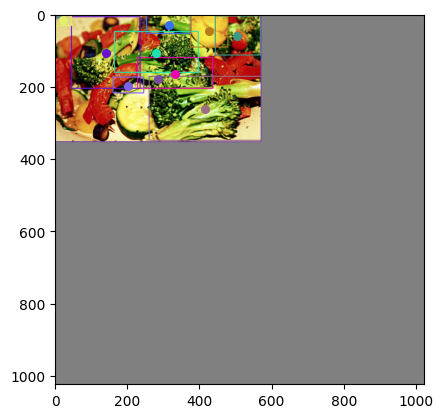

[[  5. 310. 176. 505.]
 [167. 261. 352. 512.]
 [ 15.  56. 161. 259.]
 [158.  10. 346. 258.]
 [225. 353. 254. 458.]
 [249. 104. 266. 187.]
 [  0.   0. 367. 512.]
 [  0.   0. 367. 366.]
 [  0. 235. 160. 260.]]


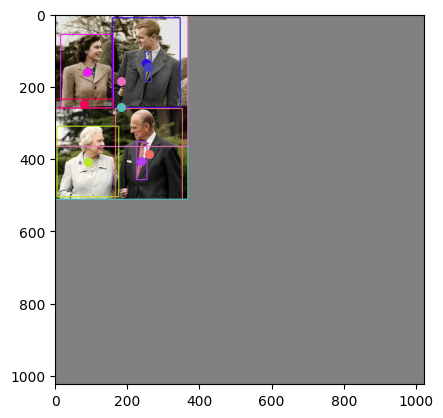

[[ 577.  889.  690. 1024.]
 [   0.    0.    0.    0.]
 [ 921.  891. 1024. 1024.]
 [ 366.  204.  554.  393.]
 [ 185.  980.  951. 1024.]
 [   0.  376. 1024. 1024.]
 [   0.    0. 1024.  661.]
 [   0.  973.  697. 1024.]
 [   0.  995.  109. 1024.]
 [   0.  856.   74.  997.]
 [   0.    0.    0.    0.]]


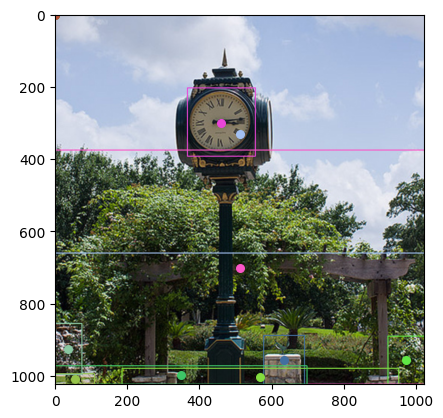

[[423.  88. 459. 112.]
 [336. 145. 386. 188.]
 [288.  94. 349. 196.]
 [ 92.  93. 188. 180.]
 [446. 129. 520. 169.]
 [117.  92. 262. 192.]
 [376. 142. 486. 197.]
 [  0.   0. 559. 133.]
 [  0.  98. 559. 371.]]


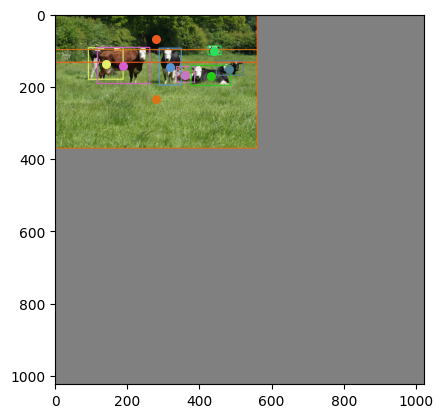

[[382.  80. 531. 448.]
 [314.  99. 404. 331.]
 [547.  31. 715. 441.]
 [109.   1. 715. 518.]
 [  1. 221. 469. 527.]
 [  0.   0. 715. 536.]]


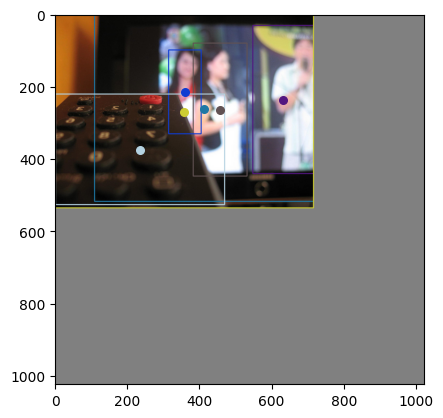

[[ 821.  758. 1018.  924.]
 [   0.   54.  358.  503.]
 [ 472.    0. 1024.  799.]
 [ 624.  822. 1024.  927.]
 [ 516.  137.  982.  855.]
 [   0.  844. 1024. 1024.]
 [ 111.    0.  921.   20.]]


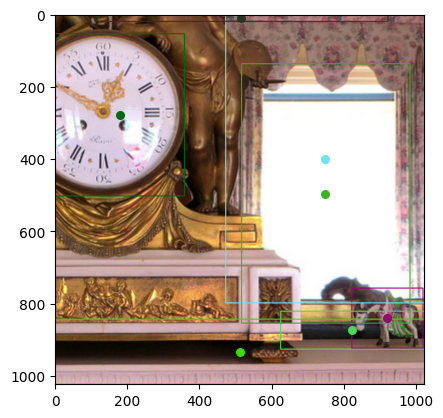

[[ 90. 149.  99. 169.]
 [ 80. 156. 105. 180.]
 [  0. 172. 222. 242.]
 [  0.   0.  90.  75.]]


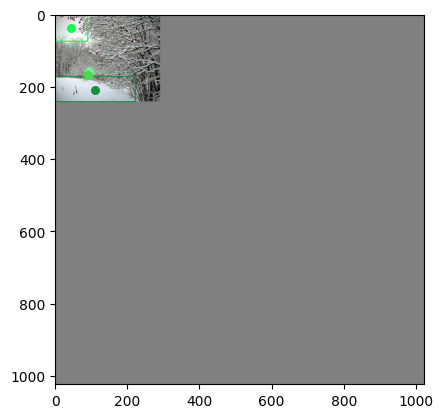

[[ 426.   94.  584.  437.]
 [ 385.  177.  528.  665.]
 [  17.  363.   58.  425.]
 [   0.    0.  824.  473.]
 [  97.  282.  760.  413.]
 [   0.  398.  824. 1024.]
 [   0.  359.  731. 1024.]]


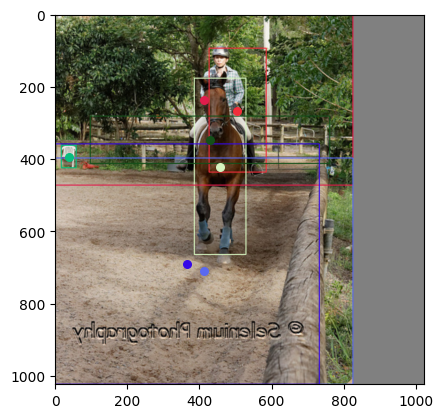

[[ 286.  108.  561.  659.]
 [ 288.  652.  408.  699.]
 [   0.  494.  706.  621.]
 [   0.  581.  706. 1024.]
 [   0.    0.  230.   44.]
 [   0.  379.  706.  806.]
 [ 225.    0.  655.   52.]
 [   0.    0.  706.  394.]]


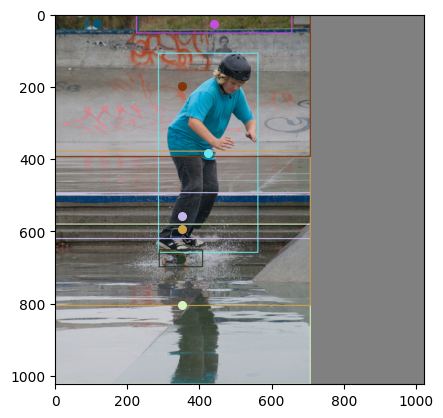

[[ 386.  197.  507.  520.]
 [ 766.   27.  966.  476.]
 [ 492.  189.  705.  830.]
 [  11.  168.  525. 1024.]
 [ 938.    3. 1024.  492.]
 [  91.    0.  907.  357.]
 [ 363.  785.  521. 1024.]
 [ 738.  581. 1021.  992.]
 [ 785.  199.  806.  227.]
 [ 424.  779.  454.  787.]
 [   0.    0.  960.  395.]
 [ 821.    0. 1024.  530.]
 [   0.  423. 1024. 1024.]
 [ 955.    0. 1024.   35.]
 [ 233.    0. 1024.  408.]]


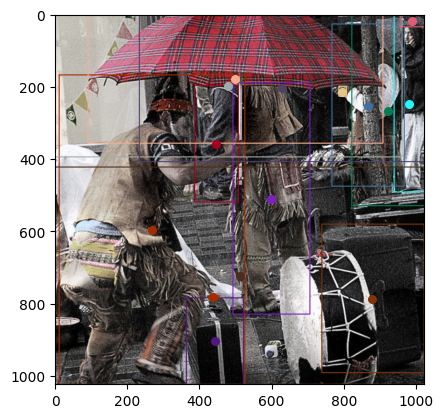

[[ 296.    0.  427.  261.]
 [   0.    0.  299.  744.]
 [ 563.  989.  607. 1024.]
 [ 688.  281.  807.  319.]
 [ 638.  489.  752.  514.]
 [   0.    0.    0.    0.]
 [ 560.  489.  696.  525.]
 [ 768.  358.  810.  389.]
 [ 793.  389.  830.  419.]
 [ 671.  275.  802.  303.]
 [ 743.  314.  802.  350.]
 [ 616.  508.  771.  539.]
 [ 605.  530.  752.  567.]
 [ 771.  331.  802.  361.]
 [ 721.  300.  805.  342.]
 [ 394.    0. 1024.   81.]
 [  44.  772.  802. 1024.]
 [   0.    0. 1024. 1024.]
 [ 232.  217.  666.  542.]]


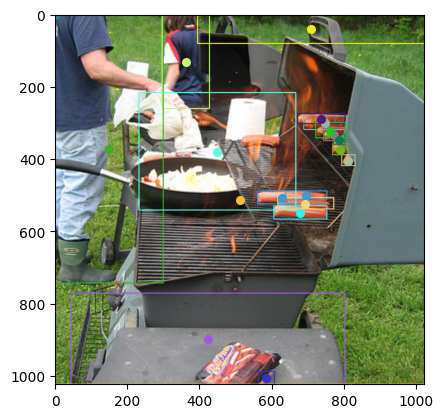

[[ 264.  232.  988.  662.]
 [ 336.  637. 1024. 1024.]
 [   0.  505.  399. 1024.]
 [  18.  190.  270.  757.]
 [   0.  752.  281. 1024.]
 [   0.    0.  681.  267.]
 [   0.    0.    0.    0.]
 [ 908.  322. 1024.  670.]
 [   0.    0. 1024.  527.]]


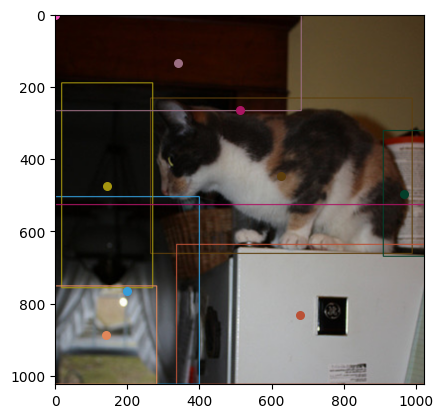

[[ 395.  129.  977. 1024.]
 [ 107.  445.  646.  673.]
 [ 927.  224.  997.  334.]
 [ 473.  239.  744.  420.]
 [ 365.  902.  777. 1024.]
 [   0.    0. 1024.  558.]
 [ 917.    0.  977.   43.]
 [   0.  615. 1024. 1024.]
 [ 749.  488.  822.  603.]
 [ 704.  322.  747.  365.]
 [   0.    0. 1024.  628.]
 [ 277.    0.  410.   31.]
 [ 797.  570. 1024.  668.]
 [ 847.  357.  930.  450.]]


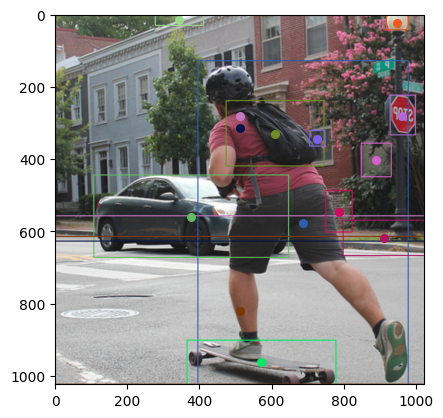

In [5]:
import cv2, random
from matplotlib import pyplot as plt
def random_color():
    rdn = random.randint(1, 1000)
    b = int(rdn * 997) % 255
    g = int(rdn * 4447) % 255
    r = int(rdn * 6563) % 255
    return b, g, r

with torch.no_grad():
    for idx, batches in enumerate(train_data_loader):
        if idx > 10:
            break
        for key, batch in batches.items():
            for idx, batch_per_image in enumerate(batch):
                obj_boxes = batch_per_image['instances'].gt_boxes.tensor
                target_img = batch_per_image["image"]
                img = target_img.permute(1, 2, 0).detach().cpu().numpy()
                obj_boxes = obj_boxes.cpu().numpy()

                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                # targets_per_image = batch_per_image["instances"].to(opt.device)
                print(obj_boxes)
                for box in obj_boxes:
                    color = random_color()
                    box = box.astype(int)
                    x1, y1, x2, y2 = box
                    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

                    x = (x1 + x2) / 2
                    y = (y1 + y2) / 2

                    plt.scatter(x, y, 30, color=[i/255 for i in color])
                    # plt.text(
                    #     x + 5,
                    #     y + 5,
                    #     label,
                    #     fontsize=10,
                    #     bbox=dict(facecolor=[i/255 for i in color], alpha=0.5),
                    #     )
                
                plt.imshow(img)
                plt.show()